## Code to run Main3d.py





> Start PINN Algorithm




> Adapting PDE


> Adapting Mesh


> Creating NeuralNet

{
    "input_shape": [
        null,
        3
    ],
    "num_hidden_blocks": 5,
    "num_neurons_per_layer": 20,
    "output_dim": 1,
    "activation": "tanh",
    "architecture_Net": "ResNet"
}

Model: "pinn__neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (Lambda)        multiple                  0         
                                                                 
 layer_0 (Dense)             multiple                  80        
                                                                 
 block_0 (Sequential)        (None, 20)                840       
                                                                 
 block_1 (Sequential)        (None, 20)                840       
                                                                 
 block_2 (Sequential)       

Loss: 8.5382e+01: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]



Computation time: 16.370392322540283 seconds

> Saving model: Test_PINN


Loss: 8.538e+01

> Ploting Solution



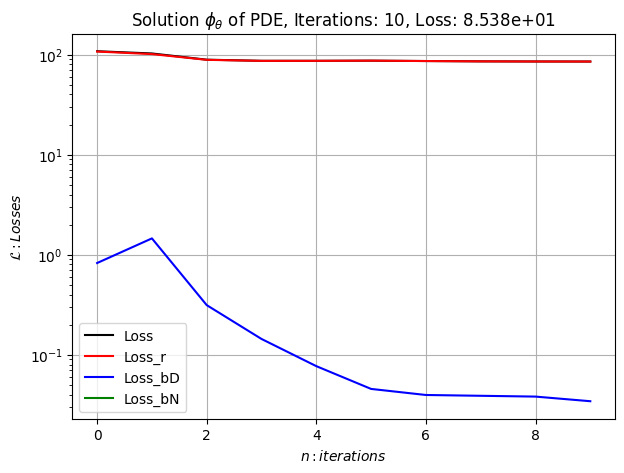

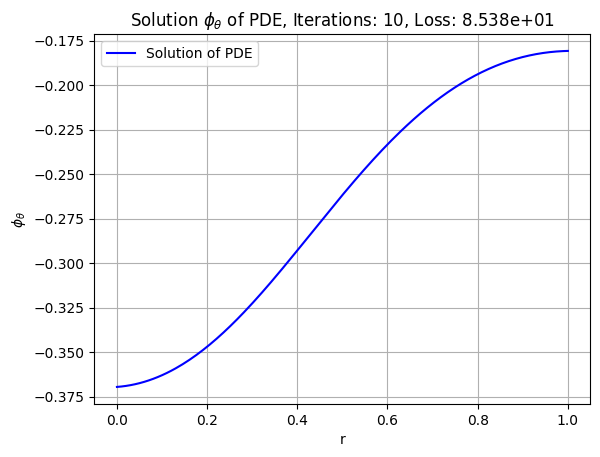

In [1]:
%run Main3d.py